In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


In [3]:
def read_vocabulary_from_file(filename):
    with open(filename, 'r', encoding='ISO-8859-1') as f:
        content = f.readlines()
        content = [x.strip() for x in content]
        content = [x for x in content if x and not x.startswith(';') and not x.endswith('+')]
    return content

In [4]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors
    return embeddings

In [5]:
pos_words = read_vocabulary_from_file('../data/opinion-lexicon-English/positive-words.txt')
neg_words = read_vocabulary_from_file('../data/opinion-lexicon-English/negative-words.txt')

In [6]:
print(f'# of pos. words: {len(pos_words)}')
print(f'# of neg. words: {len(neg_words)}')

# of pos. words: 2005
# of neg. words: 4783


In [7]:
word_dict = load_glove_embeddings('./embeddings/glove.6B.50d.txt')

In [8]:
df_pos = pd.DataFrame(pos_words, columns=['word'])
df_neg = pd.DataFrame(neg_words, columns=['word'])

df_pos['target'] = np.ones(len(df_pos), dtype=int)
df_neg['target'] = np.zeros(len(df_neg), dtype=int)


In [9]:
df_pos_shuffled = df_pos.sample(frac=1, random_state=42).reset_index(drop=True)
df_neg_shuffled = df_neg.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
df_pos_shuffled.head()

,word,target
0,navigable,1
1,encourage,1
2,dauntless,1
3,talents,1
4,dexterously,1


In [22]:
df_pos_train = df_pos_shuffled.iloc[:1500].copy()
df_neg_train = df_neg_shuffled.iloc[:1500].copy()

df_pos_test = df_pos_shuffled.iloc[1500:2000].copy()
df_neg_test = df_neg_shuffled.iloc[1500:2000].copy()

In [23]:
Xy_train = pd.concat([df_pos_train, df_neg_train], ignore_index=True)
Xy_test = pd.concat([df_pos_test, df_neg_test], ignore_index=True)

In [24]:
print(len(Xy_train))
print(len(Xy_test))

3000
1000


In [25]:
class GloveWordDataset(Dataset):
    def __init__(self, df, word_dict, embedding_dim=300):
        self.word_dict = word_dict
        self.embedding_dim = embedding_dim
        
        self.X = []
        self.y = []

        for _, row in df.iterrows():
            word = row['word']
            target = row['target']
            embedding = self.word_dict.get(word, np.zeros(self.embedding_dim))
            self.X.append(torch.tensor(embedding, dtype=torch.float32))
            self.y.append(torch.tensor(target, dtype=torch.float32))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [26]:
embedding_dim = len(next(iter(word_dict.values())))

Xy_train = GloveWordDataset(Xy_train, word_dict, embedding_dim)
Xy_test = GloveWordDataset(Xy_test, word_dict, embedding_dim)

In [27]:
batch_size = 64

train_loader = DataLoader(Xy_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Xy_test, batch_size=batch_size)

# MLP

In [28]:
class MLP(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

In [29]:
model = MLP(embedding_dim).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            6,528
├─ReLU: 1-2                              --
├─Linear: 1-3                            258
Total params: 6,786
Trainable params: 6,786
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            6,528
├─ReLU: 1-2                              --
├─Linear: 1-3                            258
Total params: 6,786
Trainable params: 6,786
Non-trainable params: 0

In [36]:
def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    """
    Trains and evaluates the model for n_epochs.
    """
    total_batches = n_epochs * len(train_loader)
    progress = tqdm(total=total_batches, desc="Training Progress", leave=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(n_epochs):
        train_loss = 0
        train_correct = 0
        train_total = 0
        y_preds, y_trues = [], []

        model.train()
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, y_pred = torch.max(output, 1)
            train_correct += (y_pred == y_train).sum().item()
            train_total += y_train.size(0)

            progress.update(1)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        val_loss = 0
        val_correct = 0
        val_total = 0

        model.eval()
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                output = model(X_val)
                loss = criterion(output, y_val)

                val_loss += loss.item()
                _, y_pred = torch.max(output, 1)
                val_correct += (y_pred == y_val).sum().item()
                val_total += y_val.size(0)

                y_preds.append(y_pred.detach().cpu())
                y_trues.append(y_val.detach().cpu())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        progress.set_postfix({
            'Epoch': f'{epoch + 1}/{n_epochs}',
            'Train Loss': f'{avg_train_loss:.4f}',
            'Val Loss': f'{avg_val_loss:.4f}',
            'Train Acc': f'{train_acc:.4f}',
            'Val Acc': f'{val_acc:.4f}'
        })
    
    y_preds = torch.cat(y_preds, dim=0).numpy()
    y_trues = torch.cat(y_trues, dim=0).numpy()

    progress.close()
    return train_losses, val_losses, train_accs, val_accs, y_preds, y_trues

In [ ]:
def plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc, y_preds, y_trues):
    
    _, ax = plt.subplots(1, 3, figsize=(14,4), layout='tight')

    ax[0].plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_xticks(range(1, n_epochs+1))
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, n_epochs + 1), train_acc, label='Training Accuracy')
    ax[1].plot(range(1, n_epochs + 1), val_acc, label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_xticks(range(1, n_epochs+1))
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0,1)
    ax[1].grid()
    ax[1].legend()

    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[2])
    
    plt.show()

Training Progress: 100%|██████████| 470/470 [00:01<00:00, 322.99it/s, Epoch=10/10, Train Loss=0.2804, Val Loss=0.3354, Train Acc=0.8720, Val Acc=0.8480]


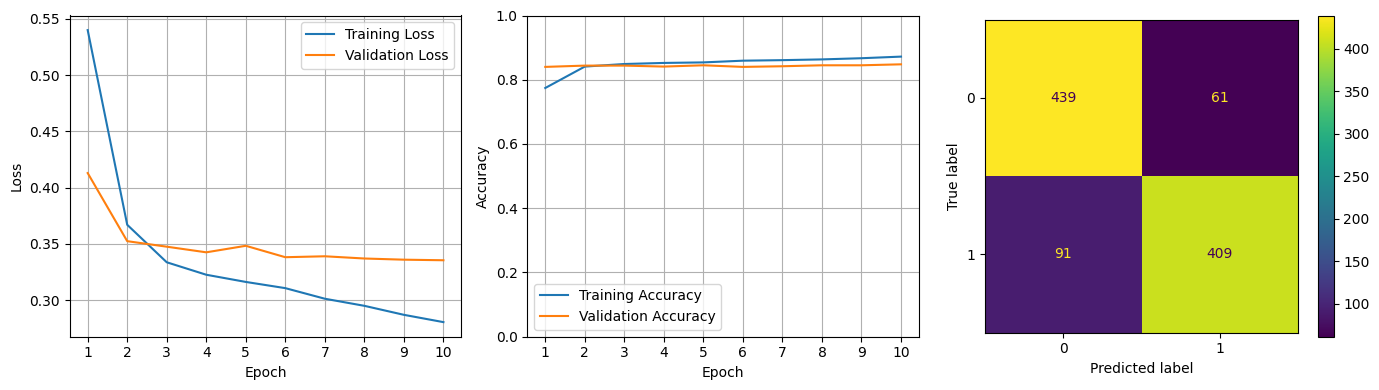

In [38]:
n_epochs = 10

model = MLP(embedding_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, train_accs, test_accs, y_preds, y_trues = trainer(model, train_loader, test_loader, optimizer, criterion, n_epochs)
plot_loss_curve(n_epochs, train_losses, test_losses, train_accs, test_accs, y_preds, y_trues)